# Create and share a reference atlas with Zenodo

In this notebook, we are going to build a reference intestine atlas and share the model weights

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
To: C:\Users\sergei.rybakov\projects\notebooks\pancreas.h5ad
126MB [00:49, 2.55MB/s] 


'pancreas.h5ad'

In [6]:
adata_all = sc.read('pancreas.h5ad')
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [8]:
source_adata

View of AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [9]:
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

### Train trVAE model on reference data

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [10]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [11]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Valid_data 1029
Condition: 0 Counts in TrainData: 821
Condition: 1 Counts in TrainData: 147
Condition: 2 Counts in TrainData: 61
 |████████------------| 40.6%  - epoch_loss:    2387 - epoch_unweighted_loss:    2387 - epoch_recon_loss:    2367 - epoch_kl_loss:      18 - epoch_mmd_loss:       2 - val_loss:    1267 - val_unweighted_loss:    1267 - val_recon_loss:    1248 - val_kl_loss:      13 - val_mmd_loss:       5
ADJUSTED LR
 |█████████-----------| 47.0%  - epoch_loss:    2357 - epoch_unweighted_loss:    2357 - epoch_recon_loss:    2338 - epoch_kl_loss:      17 - epoch_mmd_loss:       2 - val_loss:    1346 - val_unweighted_loss:    1346 - val_recon_loss:    1327 - val_kl_loss:      14 - val_mmd_loss:       5
ADJUSTED LR
 |█████████-----------| 48.4%  - epoch_loss:    2371 - epoch_unweighted_loss:    2371 - epoch_recon_loss:    2352 - epoch_kl_loss:      18 - epoch_mmd_loss:       2 - val_loss:    1302 - val_unweighted_loss:    1302 - val_recon_loss:    1284 - val_kl_loss:      14 - va

### Visualize latent representation of reference data

In [12]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


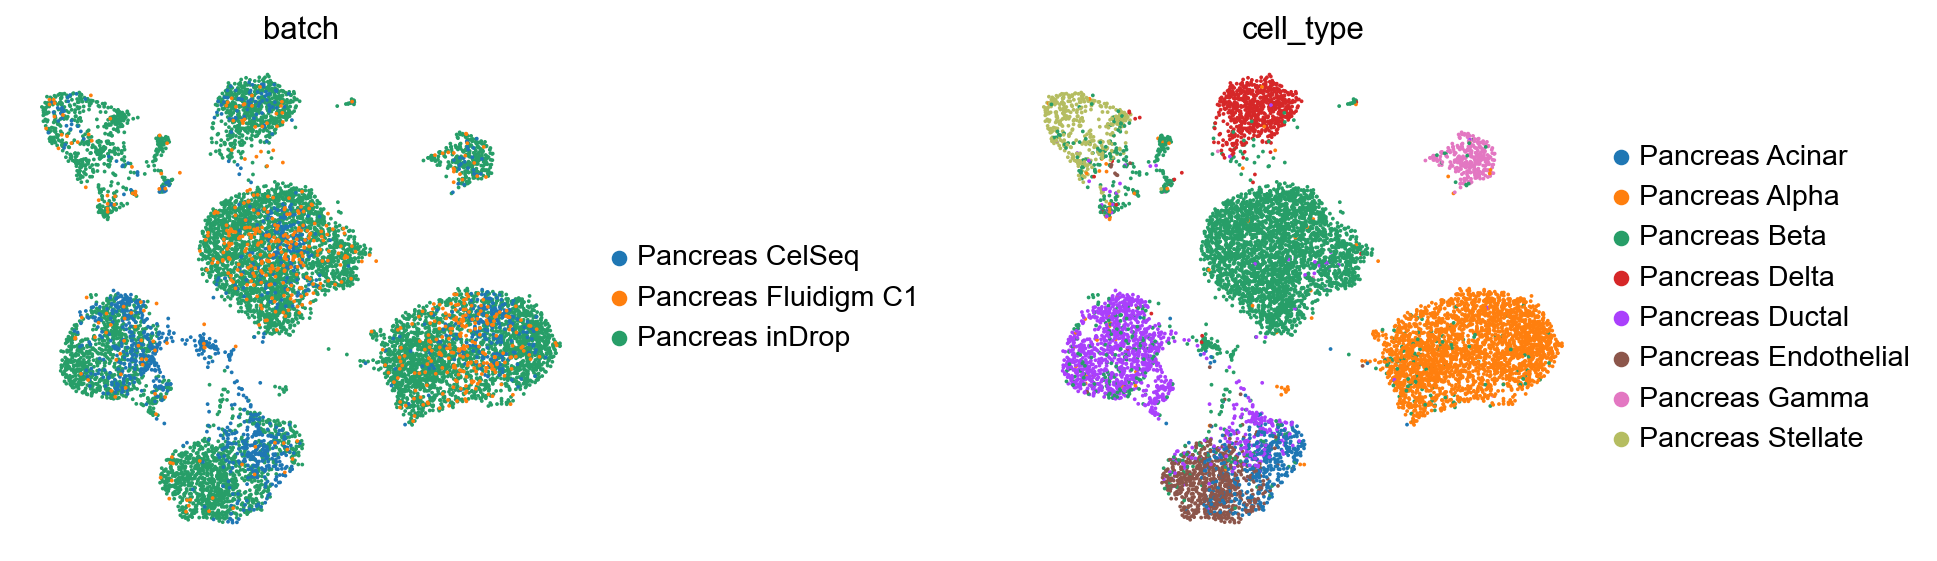

In [13]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [14]:
trvae.save('./trvae', overwrite=True)

### Upload the model to Zenodo

Another option is to upload the model to Zenodo so other researches can download it and use it for their own purposes.

You can easily get TOKEN by signing up in [**Zenodo**](https://zenodo.org/) Website and creating an app in the settings. You just have to following these steps for creating a new TOKEN: 

1. Sign in/Register in [__Zenodo__](https://zenodo.org/)
2. Go to __Applications__ page.
3. Click on __new_token__ in __Personal access tokens__ panel.
4. Give it access for `deposit:actions` and `deposit:write`.

__NOTE__: Zenodo will show the created TOKEN only once so be careful in preserving it. If you lost your TOKEN you have to create new one.

In [15]:
ACCESS_TOKEN = "YOURTOKEN"

### 1. create a deposition in your zenodo account

You can use wrapper functions in `zenodo` module in scArches package to interact with your depositions and uploaded files in Zenodo. In Zenodo, A deposition is a cloud space for a publication, poster, etc which contains multiple files.

In order to create a deposition in Zenodo, You can call our `create_deposition` function with the following parameters:

-  __access_token__: Your access token
-  __upload_type__: Type of the deposition, has to be one of the following types defined in [here](https://developers.zenodo.org/#representation).
-  __title__: Title of the deposition.
-  __description__: Description of the deposition.
-  __creators__: List of creators of this deposition. Each item in the list has to be in the following form:

```
{
    "name": "LASTNAME, FIRSTNAME", (Has to be in this format)
    "affiliation": "AFFILIATION", (Optional)
    "orcid": "ORCID" (Optional, has to be a valid ORCID)
}
```





In [16]:
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN,
                                             upload_type="other",
                                             title='scarchestest',
                                             description='test scarches upload',
                                             creators=[
                                                 {"name": "Wagenstetter, Marco", "affiliation": "helmholtz center"},
                                             ]
                                             )

New Deposition has been successfully created!


### 2. upload your model to your deposition

After creating a deposition, you can easily upload your pre-trained scArches model using `upload_model` function in `zenodo` module. This function accepts the following parameters:

- __model__: Instance of scArches' class which is trained on your task
- __deposition_id__: ID of the deposition you want to upload the model in.
- __access_token__: Your TOKEN.

The function will return the generated `download_link` in order to use and provide other 

In [17]:
download_link = sca.zenodo.upload_model('./trvae',
                                        deposition_id=deposition_id,
                                        access_token=ACCESS_TOKEN,
                                        model_name='trvae_test')

Model has been successfully uploaded


### 3. publish the created deposition

In [18]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

Deposition with id = 4321127 has been successfully published!


### Download the model and do architecture surgery and retrain with query data

In [19]:
model_path = sca.zenodo.download_model(download_link, './surg_model/', make_dir=True)

Downloading...	Finished! File has been successfully saved to ./surg_model/downloaded_model.zip.


In [20]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=model_path)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [16]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Valid_data 538
Condition: 0 Counts in TrainData: 0
Condition: 1 Counts in TrainData: 0
 |████████████--------| 64.0%  - epoch_loss:    2664 - epoch_unweighted_loss:    2664 - epoch_recon_loss:    2647 - epoch_kl_loss:      16 - epoch_mmd_loss:       0 - val_loss:    2606 - val_unweighted_loss:    2606 - val_recon_loss:    2589 - val_kl_loss:      16 - val_mmd_loss:       1
ADJUSTED LR
 |█████████████-------| 68.8%  - epoch_loss:    2576 - epoch_unweighted_loss:    2576 - epoch_recon_loss:    2559 - epoch_kl_loss:      16 - epoch_mmd_loss:       0 - val_loss:    2493 - val_unweighted_loss:    2493 - val_recon_loss:    2477 - val_kl_loss:      16 - val_mmd_loss:       1
ADJUSTED LR
 |██████████████------| 70.2%  - epoch_loss:    2528 - epoch_unweighted_loss:    2528 - epoch_recon_loss:    2512 - epoch_kl_loss:      16 - epoch_mmd_loss:       0 - val_loss:    2495 - val_unweighted_loss:    2495 - val_recon_loss:    2478 - val_kl_loss:      16 - val_mmd_loss:       1
Stopping early: no imp

### Get latent representation of query dataset and compute UMAP

In [17]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


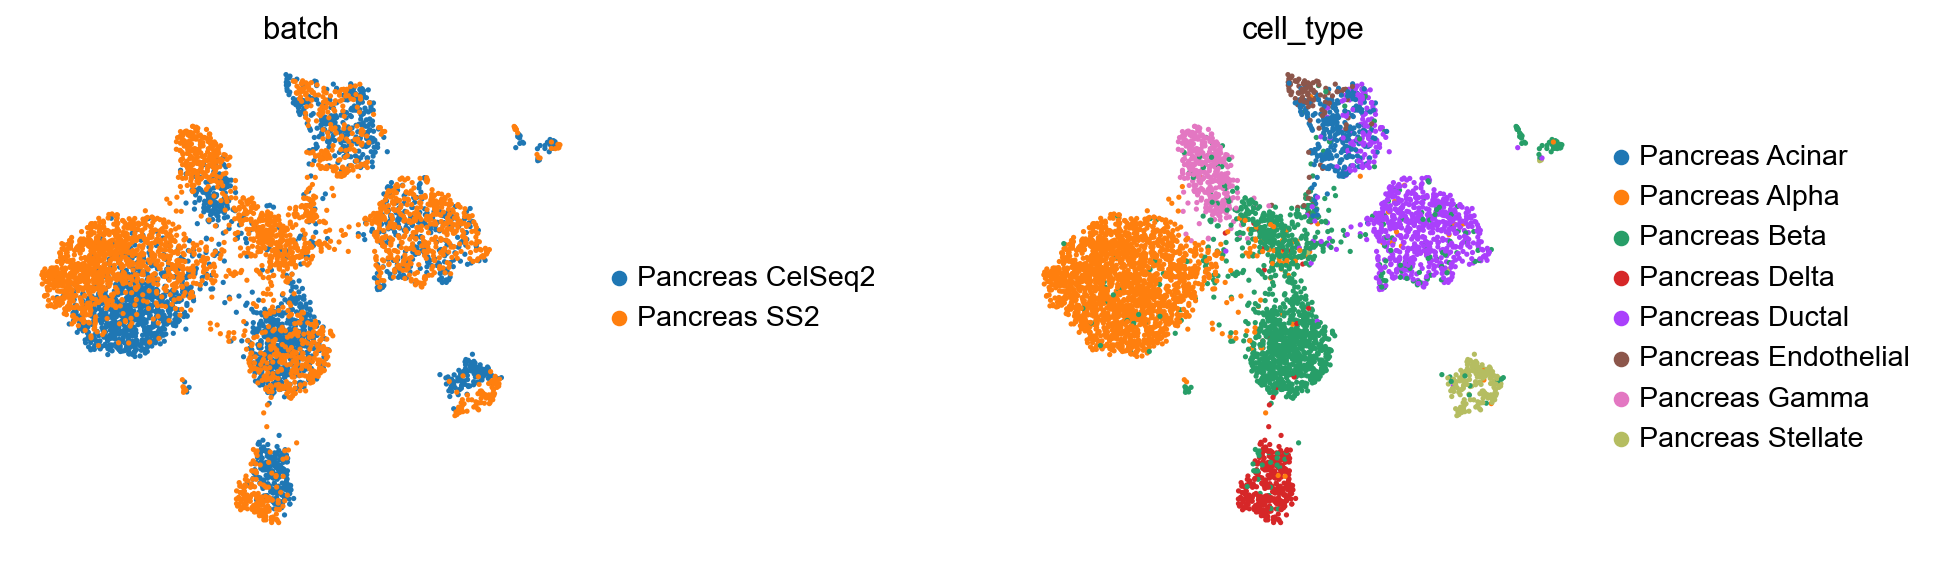

In [18]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )